In [1]:
!pip install -q torch scikit-learn numpy

In [9]:
!pip install seaborn matplotlib

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (325 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.6 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# from kaggle_secrets import UserSecretsClient
import numpy as np
import os
import json

In [ ]:
# Load from JSON 
def load_intent_data_from_json(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        intent_data = json.load(f)
    return intent_data

json_file_path = "/home/siamai/deepsad/local-deep-researcher/data/intents.json"
intent_data = load_intent_data_from_json(json_file_path)

num_intents = len(intent_data)
num_examples = sum(len(examples) for examples in intent_data.values())

print(f"Number of intents: {num_intents}")
print(f"Total number of examples: {num_examples}")


Number of intents: 22
Total number of examples: 266


In [5]:
def load_data(intent_data):
    vectorizer = TfidfVectorizer()
    texts = []
    labels = []
    original_phrases = []
    for intent, phrases in intent_data.items():
        for phrase in phrases:
            texts.append(phrase)
            labels.append(intent)
            original_phrases.append(phrase)
    X_tfidf = vectorizer.fit_transform(texts).toarray()
    label_to_index = {label: idx for idx, label in enumerate(intent_data.keys())}
    y = np.array([label_to_index[label] for label in labels])
    return X_tfidf, y, vectorizer, label_to_index, original_phrases

### Define the Neural Network Model
The neural network model for intent classification consists of three fully connected layers with ReLU activations.¶

In [6]:
class IntentClassifierModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(IntentClassifierModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 16)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(16, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        return out

### Train and Save the Model¶
We define a function to train the model and save its state dictionary.

In [7]:
def train_and_save_model(intent_data, model_path):
    try:
        # Load data
        X, y, vectorizer, label_to_index, _ = load_data(intent_data)
        input_dim = X.shape[1]  # Number of input features
        output_dim = len(label_to_index)  # Number of output classes
        
        # Initialize the model
        model = IntentClassifierModel(input_dim, output_dim)
        criterion = nn.CrossEntropyLoss()  # Loss function for classification
        optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
        
        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        
        # Train the model
        num_epochs = 300  # Number of training epochs
        for epoch in range(num_epochs):
            model.train()  # Set the model to training mode
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(X_tensor)  # Forward pass
            loss = criterion(outputs, y_tensor)  # Compute the loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update the weights
            
            # Calculate training accuracy
            _, predicted_train = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            train_accuracy = accuracy_score(y_tensor, predicted_train)  # Calculate accuracy
            
            # Print the loss and accuracy every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}')
        
        print('Training completed')
        # Save the state dictionary of the model
        torch.save(model.state_dict(), model_path)
        print(f'Model state dictionary saved to {model_path}')
        return model, vectorizer, label_to_index
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None

### Validate the Model
We define a function to validate the model, log misclassified examples, and save them to a JSON file

In [8]:
def validate_model(model, X_test, y_test, label_to_index, vectorizer, original_phrases, output_json_path):
    model.eval()
    misclassified_examples = []
    with torch.no_grad():
        X_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_tensor = torch.tensor(y_test, dtype=torch.long)
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = accuracy_score(y_tensor, predicted)
        
        # Log confusion matrix
        cm = confusion_matrix(y_tensor, predicted)
        print(f'Confusion Matrix:\n{cm}')
        
        # Log classification report
        labels = list(label_to_index.keys())
        report = classification_report(y_tensor, predicted, target_names=labels, labels=np.arange(len(labels)), zero_division=0)
        print(f'Classification Report:\n{report}')
        
        # Record misclassified examples
        misclassified_indices = np.where(predicted != y_tensor)[0]
        for idx in misclassified_indices:
            misclassified_example = {
                'text': original_phrases[idx],
                'true_label': labels[y_test[idx]],
                'predicted_label': labels[predicted[idx]]
            }
            misclassified_examples.append(misclassified_example)
            print(f'Misclassified Example - Text: {original_phrases[idx]}, True Label: {labels[y_test[idx]]}, Predicted Label: {labels[predicted[idx]]}')

        # Save misclassified examples to JSON file
        with open(output_json_path, 'w') as f:
            json.dump(misclassified_examples, f, indent=4)
        
        return accuracy, predicted

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Epoch [10/300], Loss: 3.0977, Training Accuracy: 0.0789
Epoch [20/300], Loss: 3.0895, Training Accuracy: 0.0451
Epoch [30/300], Loss: 3.0705, Training Accuracy: 0.0902
Epoch [40/300], Loss: 3.0291, Training Accuracy: 0.1241
Epoch [50/300], Loss: 2.9365, Training Accuracy: 0.0902
Epoch [60/300], Loss: 2.7342, Training Accuracy: 0.1880
Epoch [70/300], Loss: 2.4318, Training Accuracy: 0.2143
Epoch [80/300], Loss: 2.0650, Training Accuracy: 0.4135
Epoch [90/300], Loss: 1.6407, Training Accuracy: 0.5000
Epoch [100/300], Loss: 1.2394, Training Accuracy: 0.6880
Epoch [110/300], Loss: 0.8656, Training Accuracy: 0.7932
Epoch [120/300], Loss: 0.5540, Training Accuracy: 0.9624
Epoch [130/300], Loss: 0.3173, Training Accuracy: 0.9699
Epoch [140/300], Loss: 0.1757, Training Accuracy: 0.9812
Epoch [150/300], Loss: 0.1101, Training Accuracy: 0.9812
Epoch [160/300], Loss: 0.0780, Training Accuracy: 0.9812
Epoch [170/300], Loss: 0.0588, Training Accuracy: 0.9812
Epoch [180/300], Loss: 0.0464, Training 

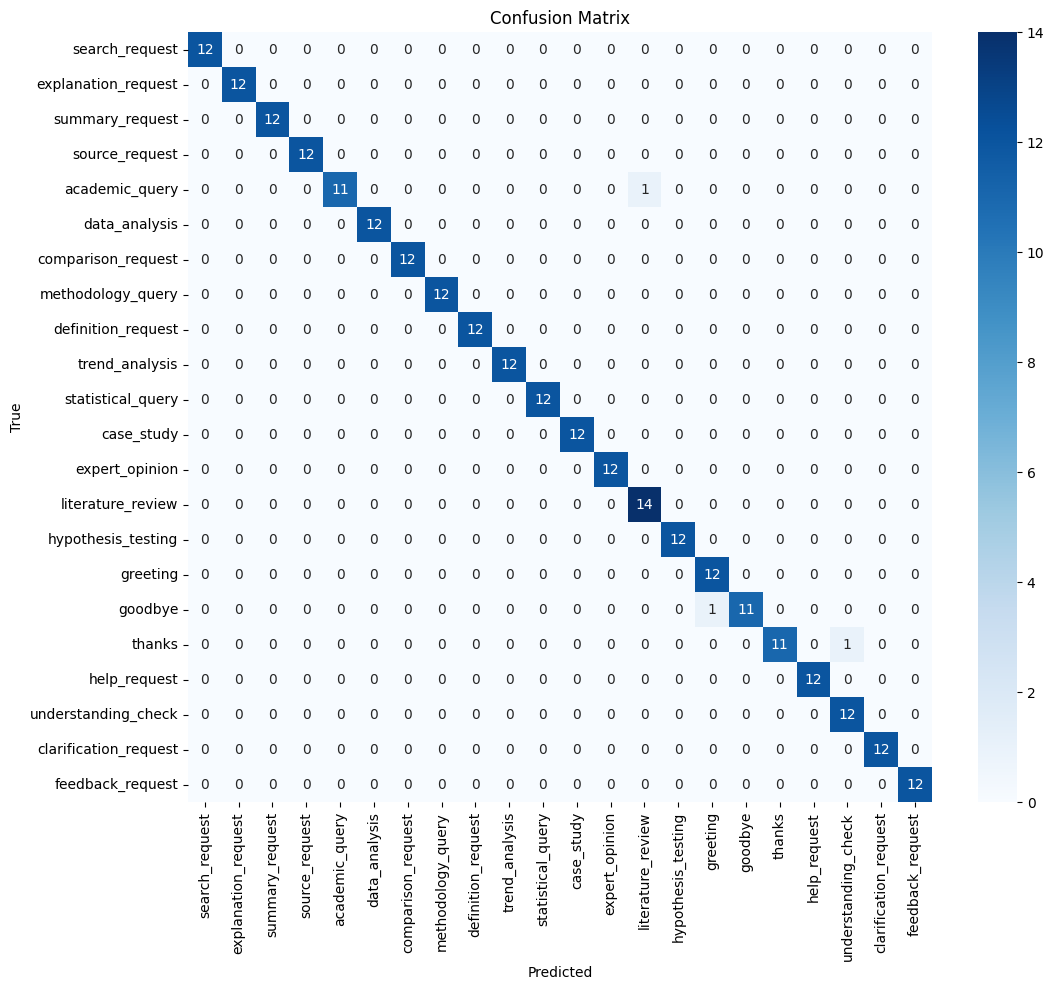

In [12]:
# Main code block
MODEL_PATH = "/home/siamai/deepsad/local-deep-researcher/data/intent_classifier_nn.pth"  # Update this to a file path
OUTPUT_JSON_PATH = "/home/siamai/deepsad/local-deep-researcher/data/misclassified_examples.json"  # Path to save the misclassified examples

if not MODEL_PATH:
    print(f"Model path is invalid: {MODEL_PATH}")
    exit(1)

# Train and save the model
model, vectorizer, label_to_index = train_and_save_model(intent_data, MODEL_PATH)

if model is None:
    print("Model training failed.")
    exit(1)

# Load data for validation
X, y, _, _, original_phrases = load_data(intent_data)

# Validate the model
accuracy, predicted = validate_model(model, X, y, label_to_index, vectorizer, original_phrases, OUTPUT_JSON_PATH)
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plot_confusion_matrix(y, predicted, labels=list(label_to_index.keys()))

In [13]:
import pandas as pd

OUTPUT_JSON_PATH = "/home/siamai/deepsad/local-deep-researcher/data/misclassified_examples.json"

# Load the misclassified examples from the JSON file
with open(OUTPUT_JSON_PATH, 'r') as f:
    misclassified_examples = json.load(f)

# Convert the misclassified examples to a DataFrame for better visualization
misclassified_df = pd.DataFrame(misclassified_examples)

# Display the DataFrame
pd.set_option('display.max_colwidth', None)  # To ensure full text is displayed
display(misclassified_df)

,text,true_label,predicted_label
0,สำรวจวรรณกรรม,academic_query,literature_review
1,สวัสดี,goodbye,greeting
2,ดีแล้ว,thanks,understanding_check
